# Using NLP Vectorization Techniques to Group Jeopardy Questions

#### By William J. Suh

## Data Science Question:

Can I categorize Jeopardy questions by topics? <br>
Most Jeopardy questions have categorical 'titles' that provide contextual clues but doesn't categorize questions by subject. What is the best clustering method to categorize them?

Clustering questions by topic enables aspiring Jeopardy contestants to study more efficiently.


## Imports

In [2]:
# usual suspects
import pandas                              as pd
import numpy                               as np
import matplotlib.pyplot                   as plt
import seaborn                             as sns

# gensim
from gensim.models                         import Doc2Vec
import gensim.models.doc2vec
from gensim                                import utils
from gensim.models.doc2vec                 import TaggedDocument, LabeledSentence
import gensim
from gensim                                import corpora, models
from gensim.test.utils                     import get_tmpfile

# random
from random import shuffle

from sklearn                               import utils

# pre-processing 
from nltk.corpus                           import stopwords
from nltk.stem                             import WordNetLemmatizer
from nltk.tokenize                         import RegexpTokenizer
import re
from string                                import digits
from bs4                                   import BeautifulSoup 


# vectorizer
from sklearn.feature_extraction.text       import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.decomposition                 import LatentDirichletAllocation

# PCA
from sklearn.decomposition import PCA

#TSNE
from sklearn.manifold import TSNE

# clusters
from sklearn.cluster import KMeans, DBSCAN

import collections
import smart_open
import random
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import normalize;

In [3]:
# Load the data
df = pd.read_csv('./JEOPARDY_CSV.csv')

In [4]:
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [5]:
df.shape

(216930, 7)

In [6]:
len(df[' Category'].unique())

27995

## Cleaning and EDA

In [7]:
# There are two NaN's that need to be dealt with. Let's load it and see what it is.

df.isnull().sum() 

Show Number    0
 Air Date      0
 Round         0
 Category      0
 Value         0
 Question      0
 Answer        2
dtype: int64

In [8]:
# Since the answers are missing, I will take it out.
df[df[' Answer'].isnull()]
df.drop(df.index[[94817, 143297]], inplace=True)

In [9]:
# fix column names
df = df.rename(columns={' Question': 'Question', ' Answer': 'Answer', ' Category': 'Category'})

In [10]:
# I will create a new feature that I will process while keeping the original questions.
df['Processed'] = df['Question']

In [11]:
# As you can see, there are a lot of repeated answers. (Listed top 100)
# They're a lot of geographical questions, some presidents, and famous historical figures

top_10 = df['Answer'].value_counts()[:10]
print(top_10.head())


China        216
Australia    215
Japan        196
Chicago      194
France       193
Name: Answer, dtype: int64


Text(0.5, 1.0, 'Top 10 Answer Distribution')

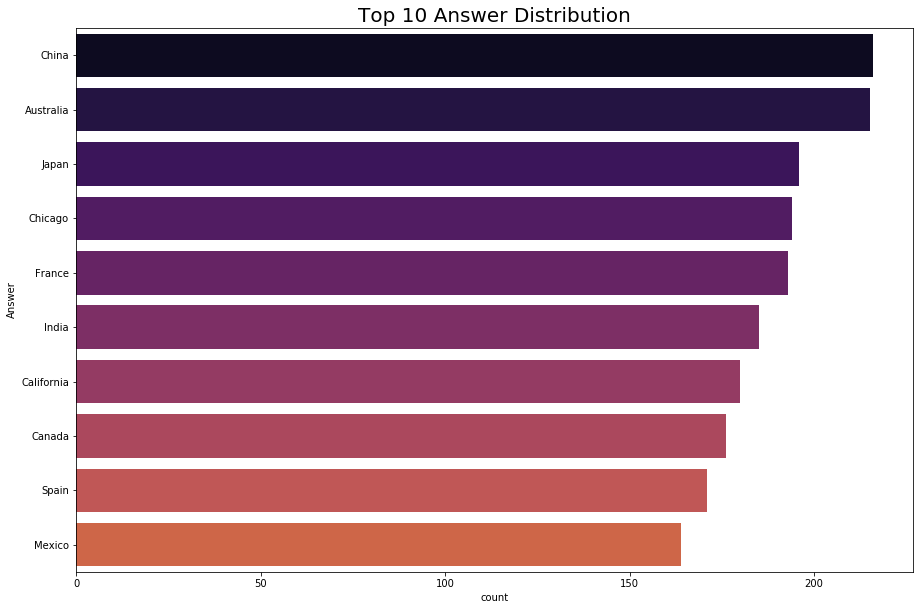

In [13]:
# Visualize top 10 Answers:
mask = df['Answer'].map(lambda x: x in top_10.index.tolist())

sns.countplot(y='Answer', data=df[mask], palette=sns.color_palette('inferno',15),order=top_10.index.tolist())
plt.gcf().set_size_inches(15,10)
plt.title('Top 10 Answer Distribution',size=20)

In [12]:
# Let's do the same with Questions:

top_10_Q = df['Question'].value_counts()
print(top_10_Q.head())

# Wait a sec! This is interesting...
# Seems like I should get rid of some more rows because some of the clues are audio/video.

[audio clue]    17
[video clue]    14
[filler]         5
(audio clue)     5
Hainan           4
Name: Question, dtype: int64


In [13]:
# drop them with masks
mask1 = df[df['Question'] == ('[audio clue]')]
mask2 = df[df['Question'] == ('[video clue]')]
mask3 = df[df['Question'] == ('[filler]')]
mask4 = df[df['Question'] == ('(audio clue)')]

df.drop(mask1.index, inplace = True) 
df.drop(mask2.index, inplace = True)
df.drop(mask3.index, inplace = True)
df.drop(mask4.index, inplace = True)
df.shape

(216887, 8)

In [14]:
# Let's try check out categories:

top_10_C = df['Category'].value_counts()[:10]
print(top_10_C)

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
Name: Category, dtype: int64


Text(0.5, 1.0, 'Top 10 Categories')

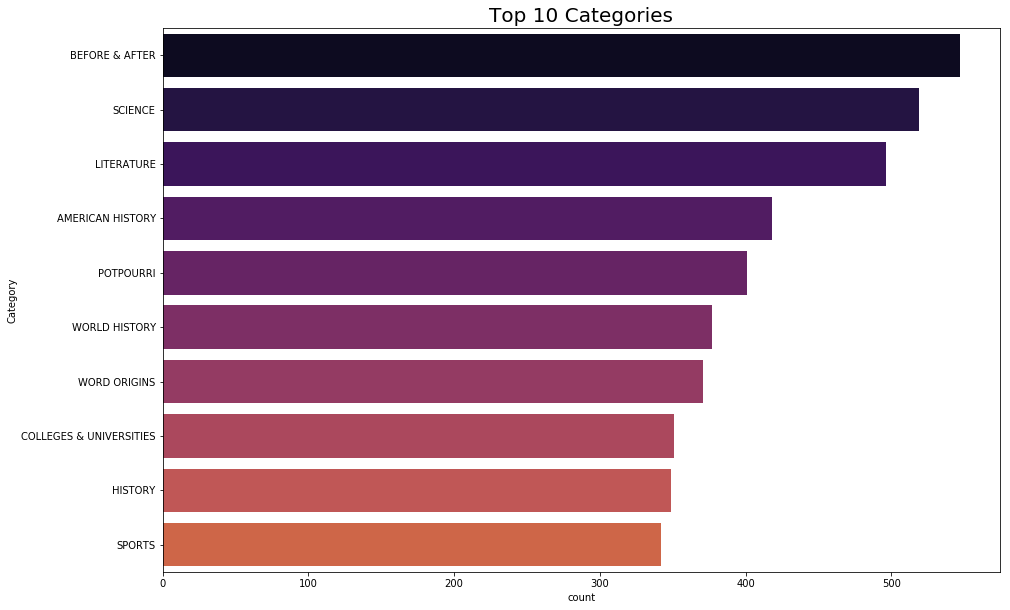

In [17]:
# Visualize top 10 Categories: 
mask = df['Category'].map(lambda x: x in top_10_C.index.tolist())

sns.countplot(y='Category', data=df[mask], palette=sns.color_palette('inferno',15),order=top_10_C.index.tolist())
plt.gcf().set_size_inches(15,10)
plt.title('Top 10 Categories',size=20)

## Category Titles and Thoughts on the Dataset

There are many category titles that contextualize answers and act as clues. There are 216930 questions in this dataset and 27995 unique categories. Although some category titles repeat themselves, I would like to further synthesize these contextual category titles into larger categories. 

My hypothesis for accomplishing this is by picking out key question words such as, "How", "Where", "When", "What", "Who". Although there are finer ways to categorize questions, this would be a good start. I might also explore by grouping key words because it might hint at similar topics.



## Pre-processing


In [15]:
# Use BeautifulSoup to get rid of html artifacts.

df['processed'] = df['Question'].map(lambda x: BeautifulSoup(x,'lxml').get_text())

In [16]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
df['processed'] = [lemmatizer.lemmatize(word) for word in df['processed']]

# lower case
df['processed'] = [word.lower() for word in df['processed']]
df['Answer'] = [word.lower() for word in df['Answer']]

# get rid of all special characters using Regex
df['processed'] = [re.sub('[^A-Za-z0-9]+', ' ', word) for word in df['processed']]
df['Answer'] = [re.sub('[^A-Za-z0-9]+', ' ', word) for word in df['Answer']]

In [17]:
# double check:
print('old:', df['Question'][29], '\n')
print('new:', df['processed'][29])
print('answer:', df['Answer'][29])

old: <a href="http://www.j-archive.com/media/2004-12-31_DJ_23.mp3">Beyond ovoid abandonment, beyond ovoid betrayal... you won't believe the ending when he "Hatches the Egg"</a> 

new: beyond ovoid abandonment beyond ovoid betrayal you won t believe the ending when he hatches the egg 
answer: horton


In [18]:
# Save cleaned questions 
np.savetxt('jeopardy.txt', df['processed'], fmt='%s', delimiter="\t")  

In [22]:
# more EDA on the vectors, 
# logreg, CART/boosting model, 

## Count Vectorization on Words.

Before I can use different clustering methods, I need to vectorize my questions. Although I will use both CountVectorizer and TFIDF, I decided to use CountVectorizer first because I think the common question words matter in this case. If I add more weight to unique words using TFIDF, I might discount the importance of common question words present in the questions. 

Furthermore, words that are prominent might cluster into a topic as well. I will lose this ability if I use TFIDF.

On a side note, I realize CountVectorizing on words is naive but I wanted to see how a basic model looks.

In [19]:
question_list = list(df['processed']) 

### CVEC histogram view

In [20]:
cvec = CountVectorizer(max_features=30000)
X_text = cvec.fit_transform(df['Question'])
X_text

<216887x30000 sparse matrix of type '<class 'numpy.int64'>'
	with 2844181 stored elements in Compressed Sparse Row format>

In [21]:
X_text = pd.DataFrame(X_text.toarray(), columns=cvec.get_feature_names())
X_text_sample = X_text.sample(12000)

In [22]:
X_text_sum = X_text_sample.sum()

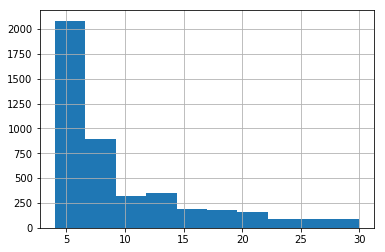

In [23]:
X_text_sum[X_text_sum.between(4, 30)].hist()

In [24]:
#X_text_sum[X_text_sum > 0].sort_values(ascending = False)

In [25]:
vec = CountVectorizer(min_df = .1, max_df = .75)
question_vec = vec.fit_transform(question_list)
question_vec_df = pd.DataFrame(question_vec.toarray(), columns = vec.get_feature_names())
question_vec_array = question_vec.toarray()

In [26]:
question_vec_df.head()

,for,in,is,it,of,on,the,this,to,was
0,2,0,0,0,1,0,1,1,0,1
1,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,3,0,1,1,0,0
3,0,1,0,0,0,1,1,1,0,0
4,0,0,0,0,5,0,3,0,0,0


In [27]:
# I have to create a dense matrix to run it through PCA.
# I need to reduce dimensionality to run it through KMeans and DBSCAN.

dense_vec = [[b for b in sub] for sub in question_vec_array]

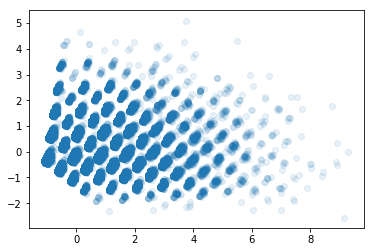

In [74]:
# Visualize PCA that's from CountVectorizer

pca = PCA(n_components=2).fit(dense_vec)
data2D = pca.transform(dense_vec)
plt.scatter(data2D[:,0], data2D[:,1], alpha = .1)
plt.show()  

In [75]:
# PCA'd features in a dataframe to put KMeans centroids on it.

data2D_df = pd.DataFrame(data2D)
data2D_df.head()

,0,1
0,0.342123,-0.511505
1,-0.210877,-0.310657
2,1.308058,-0.418761
3,0.017835,0.731937
4,3.755074,-2.146939


# CountVec Clustering 

### KMeans

In [77]:
# initialize kmeans 10, 50, 100
kmeans_10 = KMeans(n_clusters = 10)
kmeans_50 = KMeans(n_clusters= 50)
kmeans_100 = KMeans(n_clusters= 100)

In [78]:
# fit kmeans 
model_10 = kmeans_10.fit(data2D) 
model_50 = kmeans_50.fit(data2D)
model_100 = kmeans_100.fit(data2D)

In [79]:
# load cluster centers:
clusters_10 = model_10.cluster_centers_
clusters_50 = model_50.cluster_centers_ 
clusters_100 = model_100.cluster_centers_


In [80]:
# transform cluster centers in to dataframe

centroids_10 = pd.DataFrame(clusters_10)
centroids_50 = pd.DataFrame(clusters_50)
centroids_100 = pd.DataFrame(clusters_100)

In [81]:
# apply centroid distance class to data2D_df

data2D_df['nearest_10'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_10.sub(x[[0,1]]), axis =1).argmin(), axis = 1)

data2D_df['nearest_50'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_50.sub(x[[0,1]]), axis =1).argmin(), axis = 1)

data2D_df['nearest_100'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_100.sub(x[[0,1]]), axis =1).argmin(), axis = 1)

### KMeans 10, 50, 100 clustered questions


In [82]:
# grab and use the index of the nearest_10, nearest_50,nearest_100 class so I can use it on the original df.

kmeans10_cluster_one = data2D_df[data2D_df['nearest_10'] == 9].index
kmeans50_cluster_one = data2D_df[data2D_df['nearest_50'] == 49].index
kmeans100_cluster_one = data2D_df[data2D_df['nearest_100'] == 99].index

kmeans50_cluster_48 = data2D_df[data2D_df['nearest_50'] == 48].index

In [86]:
# The clustering isn't good. The questions do not cluster well. 

# Since it didn't cluster well, I will move on to KMeans with 50 centroids to see if it does any better.
for i in kmeans100_cluster_one[:10]:
    print('KMeans 10 cluster one:', df['Question'][i])

KMeans 10 cluster one: (<a href="http://www.j-archive.com/media/2009-05-08_DJ_30.jpg" target="_blank">Jimmy of the Clue Crew shows a geometric diagram on the monitor.</a>)  Half the base times the height gives the area of a triangle; for a <a href="http://www.j-archive.com/media/2009-05-08_DJ_30a.jpg" target="_blank">cylinder</a>, the area of the base times the height gives this measurement
KMeans 10 cluster one: (<a href="http://www.j-archive.com/media/2011-05-05_J_05.jpg" target="_blank">Sarah of the Clue Crew shows a map on the monitor.</a>)  The northwest angle belongs to the U.S., although it doesn't look that way; it's the only part of the lower 48 that extends miles north of this parallel of latitude
KMeans 10 cluster one: The sum of the squares of the lengths of the legs of a right triangle is equal to the square of the length of this
KMeans 10 cluster one: (<a href="http://www.j-archive.com/media/2012-01-10_DJ_18.jpg" target="_blank">Jimmy of the Clue Crew stands on the steps 

In [ ]:
# KMeans 50 didn't cluster questions well either... moving to KMeans 100 
# for i in kmeans50_cluster_one:
#     print('KMeans 50 cluster one:', df['Question'][i])

# I tried cluster no.48 because most of them were outliers and I wanted to see what kind of questions those were.
# for i in kmeans50_cluster_48:
#     print('KMeans 50 cluster 48:', df['Question'][i]) 

In [ ]:
# for i in kmeans100_cluster_one:
#     print('KMeans 100 cluster one:', df['Question'][i])

In [45]:
# apply centroid distance class to sample

data2D_df['nearest_10'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_10.sub(x[[0,1]]), 
                                                                   axis =1).argmin(), axis = 1)

data2D_df['nearest_50'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_50.sub(x[[0,1]]),
                                                                   axis =1).argmin(), axis = 1)

data2D_df['nearest_100'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_100.sub(x[[0,1]]),
                                                                    axis =1).argmin(), axis = 1)


In [84]:
data2D_df.head()

,0,1,nearest_10,nearest_50,nearest_100
0,0.342123,-0.511505,8,30,3
1,-0.210877,-0.310657,4,5,45
2,1.308058,-0.418761,3,42,8
3,0.017835,0.731937,1,10,74
4,3.755074,-2.146939,9,36,94


### KMeans 10, 50, 100 Visualization

IndexError: index 10 is out of bounds for axis 0 with size 10

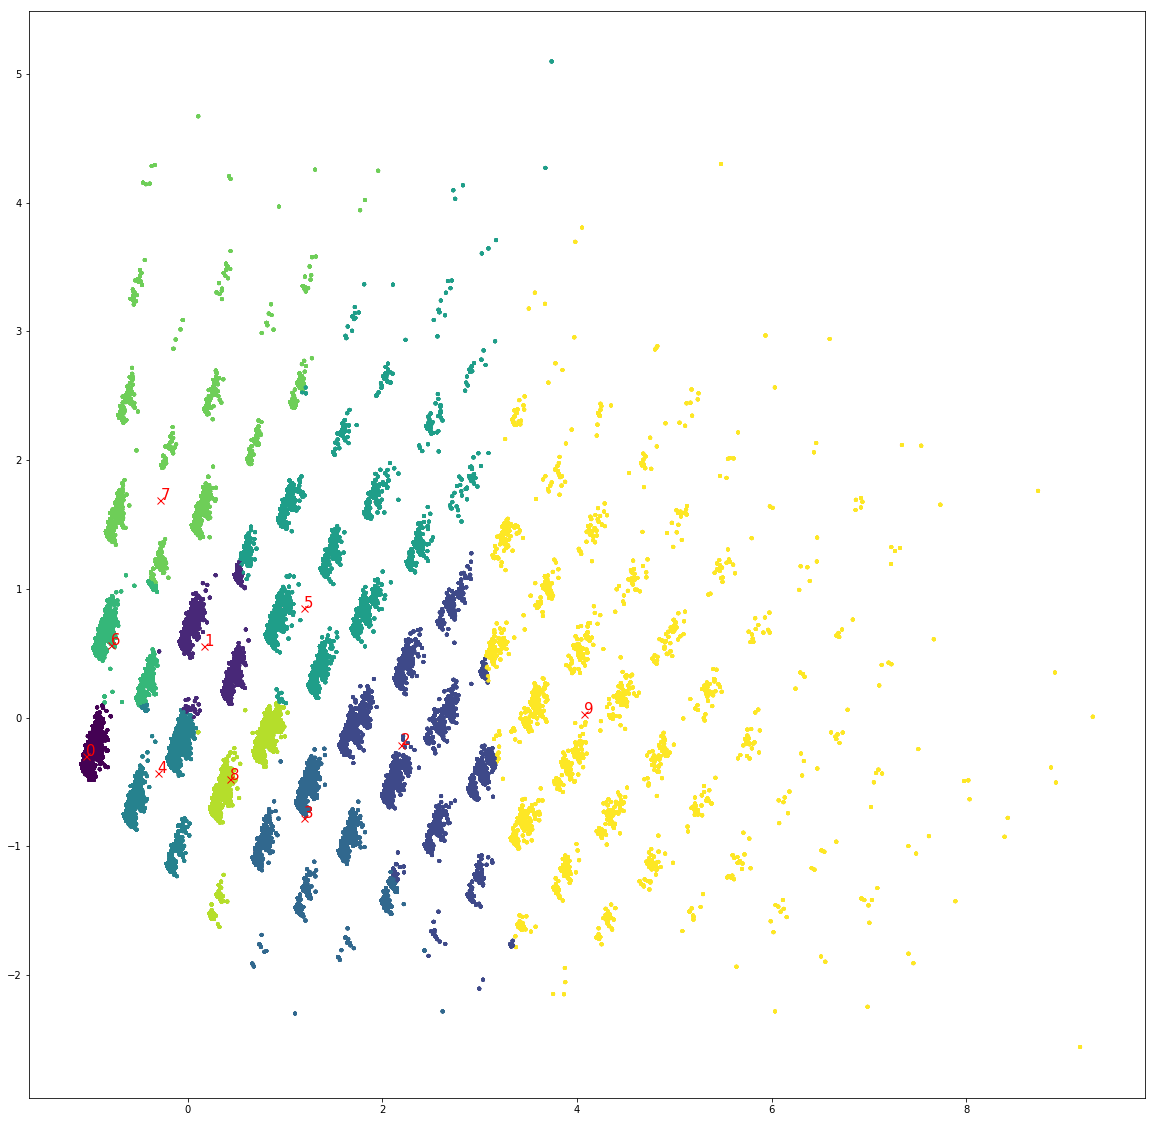

In [85]:
# kmeans 10 on data2D_df

plt.figure(figsize=(20,20))

for i in range(0, 10000):
    
    # scatter plot of samples
    cluster = data2D_df[data2D_df['nearest_10'] == i]
    plt.scatter(data2D_df[0],data2D_df[1], s=8, c= data2D_df['nearest_10'])
    
    centroid = kmeans_10.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = data2D_df['nearest_10'])
    plt.annotate(str(i),centroid,size=15, color = 'red')

IndexError: index 50 is out of bounds for axis 0 with size 50

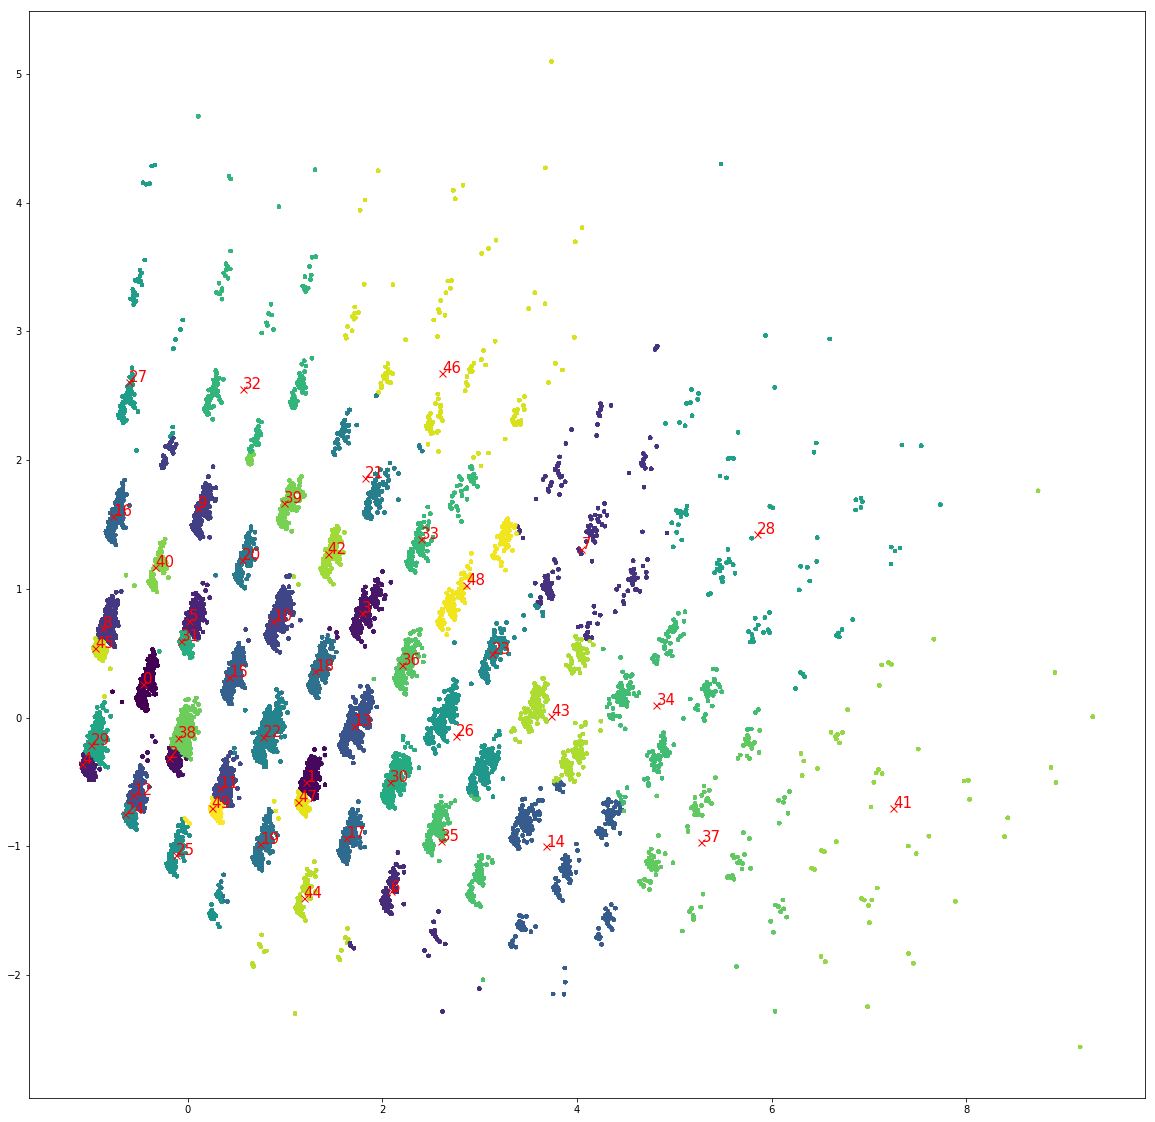

In [51]:
# kmeans 50 on data2D_df

plt.figure(figsize=(20,20))

for i in range(0, 10000):
    
    # scatter plot of samples
    cluster = data2D_df[data2D_df['nearest_50'] == i]
    plt.scatter(data2D_df[0],data2D_df[1], s=8, c= data2D_df['nearest_50'])
    
    # centroid is kmeans center
    centroid = kmeans_50.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = data2D_df['nearest_50'])
    plt.annotate(str(i),centroid,size=15, color = 'red')

IndexError: index 100 is out of bounds for axis 0 with size 100

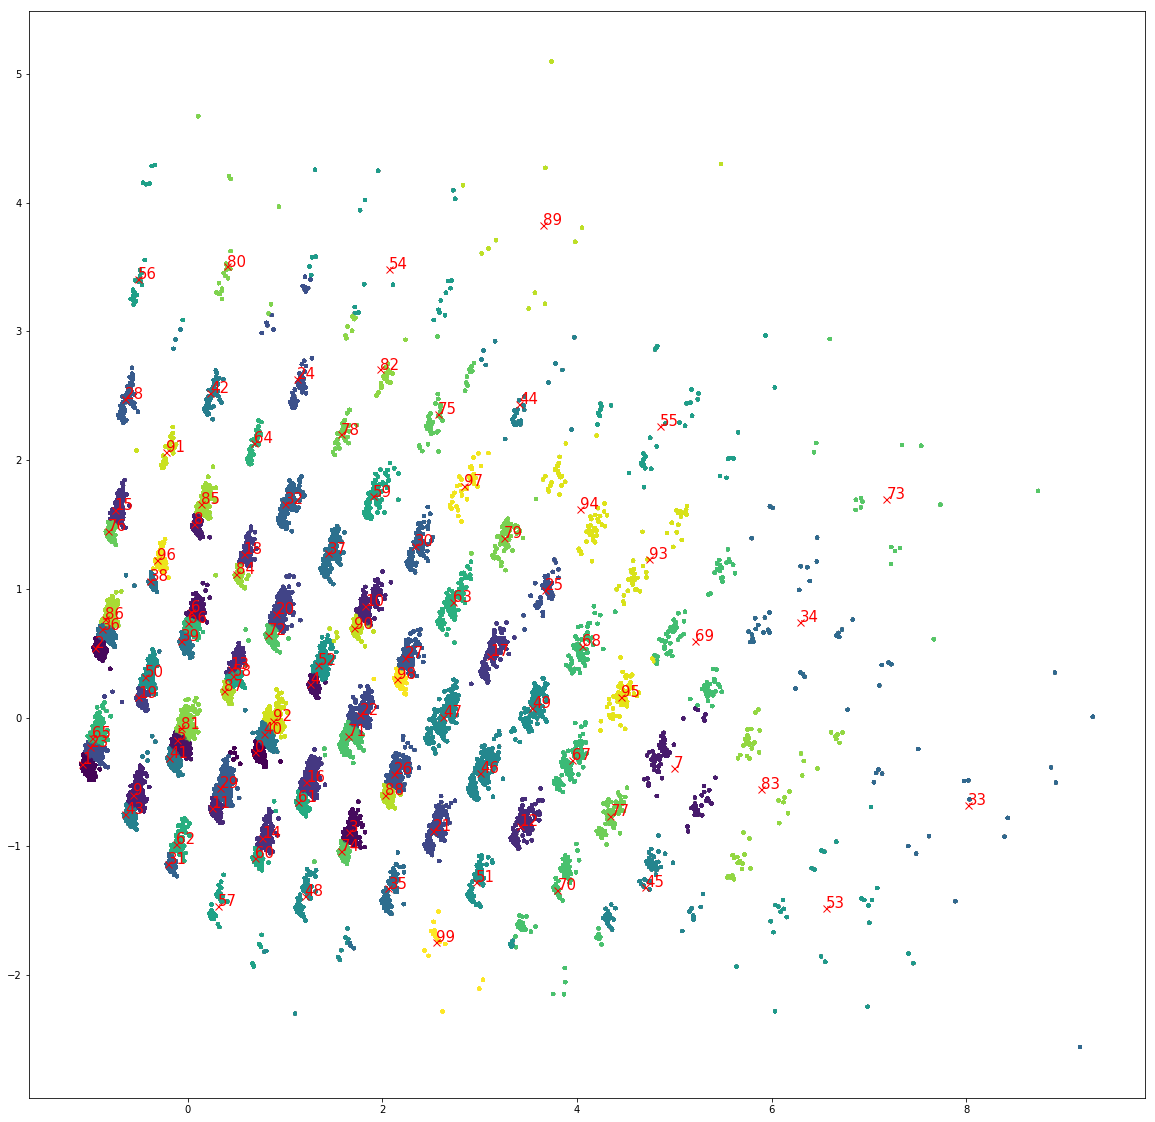

In [52]:
# kmeans 100 on data2D_df

plt.figure(figsize=(20,20))

for i in range(0, 10000):
    
    # scatter plot of samples
    cluster = data2D_df[data2D_df['nearest_100'] == i]
    plt.scatter(data2D_df[0], data2D_df[1], s=8, alpha = .3,  c = data2D_df['nearest_100'])
    
    # centroid is kmeans center
    centroid = kmeans_100.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = data2D_df['nearest_100'])
    plt.annotate(str(i),centroid,size=15, color = 'red')

## KMeans Observations:

Visually checking KMeans with 10, 50, 100 centroids showed that none of them did a satisfactory job of grouping (especially the outliers). KMeans with 100 centroids is interesting in that there are many centroids within a dense cluster but it isn't too informative.

This is further supported 

### DBSCAN with eps = 0.1, min sample =10

Data2D_df is too big for my computer to compute. Thus, I had to sample 10,000 observations. 

In [41]:
# create an array from data2D_df to sample from. 
data2D_df = pd.DataFrame(data2D)
data2D_df['class'] = data2D_df.index

data2D_array = data2D_df.values

#use np.random.choice(30000) on data2D for sampling/visualization purposes.

sample = data2D_array[np.random.randint(data2D_array.shape[0], size=30000), :]
sample = pd.DataFrame(sample)

#rename '2' to index
sample = sample.rename(columns={2: 'index from data2D_df'})
sample.head()

,0,1,index from data2D_df
0,0.471912,0.315445,126467.0
1,-0.870931,0.718804,143043.0
2,-1.042644,-0.420479,216293.0
3,0.330201,-0.558863,161489.0
4,1.624852,-0.883937,96989.0


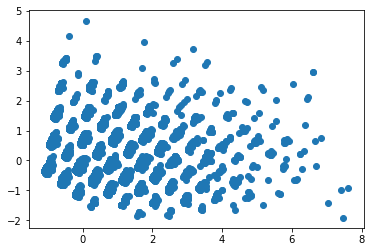

In [54]:
# visually check sample
plt.scatter(sample[0], sample[1])

In [42]:
# convert data2D_df to array to use it with DBSCAN
sample_array = sample[[0,1]].values
sample_array

array([[ 0.47191159,  0.3154451 ],
       [-0.87093087,  0.71880386],
       [-1.04264364, -0.42047917],
       ...,
       [ 0.46062599,  0.41019555],
       [-0.19480938, -0.33219161],
       [ 3.02090444, -1.0697131 ]])

In [43]:
# Initialize DBSCAN

db = DBSCAN(eps=0.1, min_samples=10).fit(sample_array)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [44]:
# create a labels class for visualization

sample['db_labels'] = db.labels_

In [45]:
# Number of clusters in labels, ignoring noise if present.

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [46]:

sample_df = pd.DataFrame(sample_array)

Text(0.5, 1.0, 'DBSCAN with PCA')

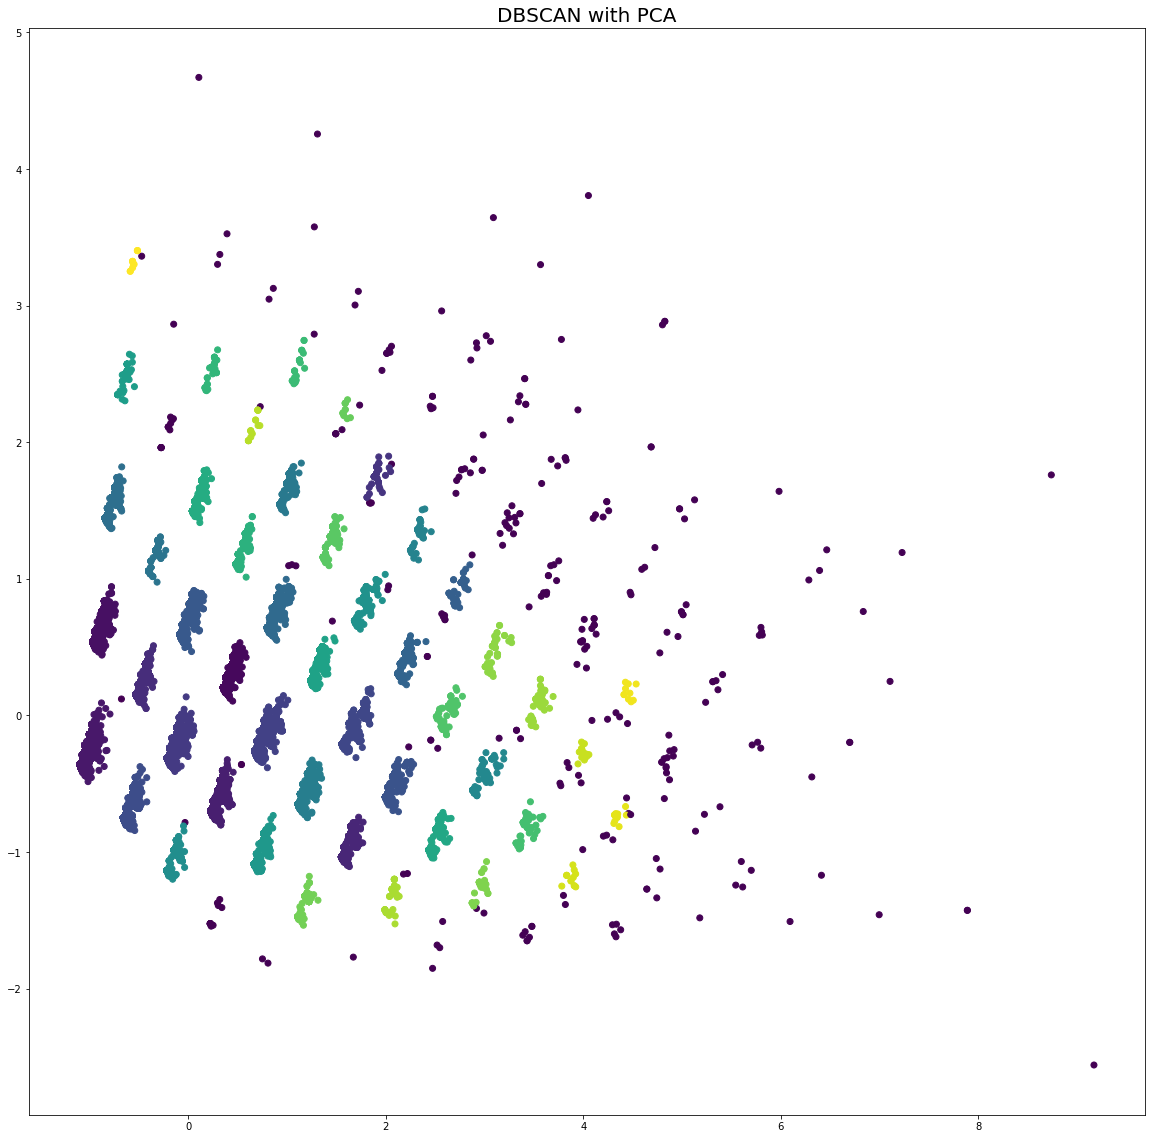

In [47]:
# Visualize DBScan with epsilon = 0.2, min_samples = 10:
fig = plt.figure(figsize=(20,20))
plt.scatter(sample[0], sample[1], c = db.labels_)
plt.title('DBSCAN with PCA', fontsize = '20')

In [48]:
df.shape

(216887, 9)

In [49]:
# Qualitative Metric:
# I tried different db_labels and none of them clustered too well.

zero_index = sample[sample['db_labels'] == 45].index

for i in zero_index:
    print(df['Question'][i])

Herbie, the endearing Volkswagen in a classic Disney film
Let's make Craig Claiborne's recipe for an upside-down type of this fruit pie; it's a lot like tarte tatin
Alisa Berk played Kala, the primate mother, in this 1984 film subtitled "The Legend of Tarzan, Lord of the Apes"
On a report card
You'll find dancing noodles on the website of Real Torino, which markets rigatoni, spaghetti & other types of this
This German completed his "Chromatic Fantasy And Fugue" for harpsichord in 1730
1926's top 2 fiction sellers were John Epskine's "The Private Life of Helen of Troy" & this Anita Loos book
Ah-one & ah-two, it's the marine snail in the photo looking at you
A Polish-born writer of short stories: Bashevis
These fluid-filled swellings on the skin are most commonly caused by burns or friction


## TFIDF Clustering on Sample Size = 20000

In [50]:
# due to computational reasons, I decided to take 20,000 random samples from the dataset

question_list_sample = random.sample(question_list, 20000)
question_list_sample[:10]

['instead of an elaborate meal this southerner served peanuts pretzels',
 'this art of transmuting metals broke up into branches the esoterics drew away from lab practices',
 'the wwii diary of this dutch jewish teenager is widely read by young japanese girls',
 'a private vip room at a sports stadium',
 'this film set in the bronx featured angie clara as well as the ernest borgnine title character',
 'francisco franco chiang kai shek used this title as supreme commander of their countries armies',
 'in 1901 botanist hugo de vries coined this term to describe sudden genetic change',
 'he was bourne again in 2004 when he returned as jason bourne in the bourne supremacy ',
 'in 1818 this argentine general refused the governorship of chile in favor of b o higgins',
 'opened in 1976 it s the tallest structure in canada']

In [51]:
# initialize TFIDF and convert output to array.

tfidf = TfidfVectorizer(stop_words = "english")
question_tfidf = tfidf.fit(question_list_sample)

data2D_df  = pd.DataFrame(tfidf.transform(question_list_sample).todense(),
                   columns = tfidf.get_feature_names(),
                   )
data2D_df.shape

(20000, 28774)

In [52]:
# dimensionality reduction using PCA

pca = PCA(n_components =2).fit(data2D_df)
data2D_df = pca.transform(data2D_df)
data2D_df

array([[-0.00987508, -0.00435149],
       [-0.00933724, -0.00415439],
       [-0.01557628, -0.00836111],
       ...,
       [-0.00718279, -0.01149534],
       [-0.0138728 , -0.00673718],
       [-0.01865096, -0.0074264 ]])

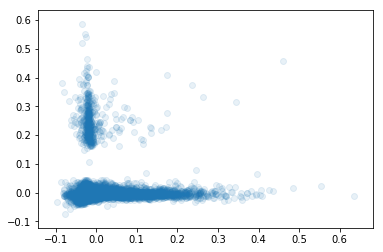

In [53]:
# visualize PCA

plt.scatter(data2D_df[:,0], data2D_df[:,1], alpha = .1)
plt.show()  

In [54]:
# convert data2D_df from array to dataframe
data2D_df = pd.DataFrame(data2D_df)
data2D_df.head()

,0,1
0,-0.009875,-0.004351
1,-0.009337,-0.004154
2,-0.015576,-0.008361
3,-0.008035,-0.006076
4,-0.041354,-0.023040


## KMeans 10

In [55]:
# data2D_array = data2D_df[[0,1]].values
# data2D_array

In [56]:
kmeans_10 = KMeans(n_clusters = 10) 
model_10 = kmeans_10.fit(data2D_df) 
clusters_10 = model_10.cluster_centers_ 
centroids_10 = pd.DataFrame(clusters_10)

In [58]:
# apply class by distance 
data2D_df['nearest_10'] = data2D_df.apply(lambda x: np.linalg.norm(centroids_10.sub(x[[0,1]]), axis =1).argmin(), axis = 1)

In [67]:
kmeans10_cluster_one = data2D_df[data2D_df['nearest_10'] == 1].index

In [69]:
# KMeans 10 question group 9 doesn't seem to be grouping too well.

for i in kmeans10_cluster_one[:10]:
    print(df['Question'][i])

For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory
No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves
The city of Yuma in this state has a record average of 4,055 hours of sunshine each year
In 1963, live on "The Art Linkletter Show", this company served its billionth burger
No. 8: 30 steals for the Birmingham Barons; 2,306 steals for the Bulls
In the winter of 1971-72, a record 1,122 inches of snow fell at Rainier Paradise Ranger Station in this state
This housewares store was named for the packaging its merchandise came in & was first displayed on
"And away we go"
In 1000 Rajaraja I of the Cholas battled to take this Indian Ocean island now known for its tea
On June 28, 1994 the nat'l weather service began issuing this index that rates the intensity of the sun's radiation


In [70]:
#add index to data2D_df

data2D_df['index'] = data2D_df.index

IndexError: index 10 is out of bounds for axis 0 with size 10

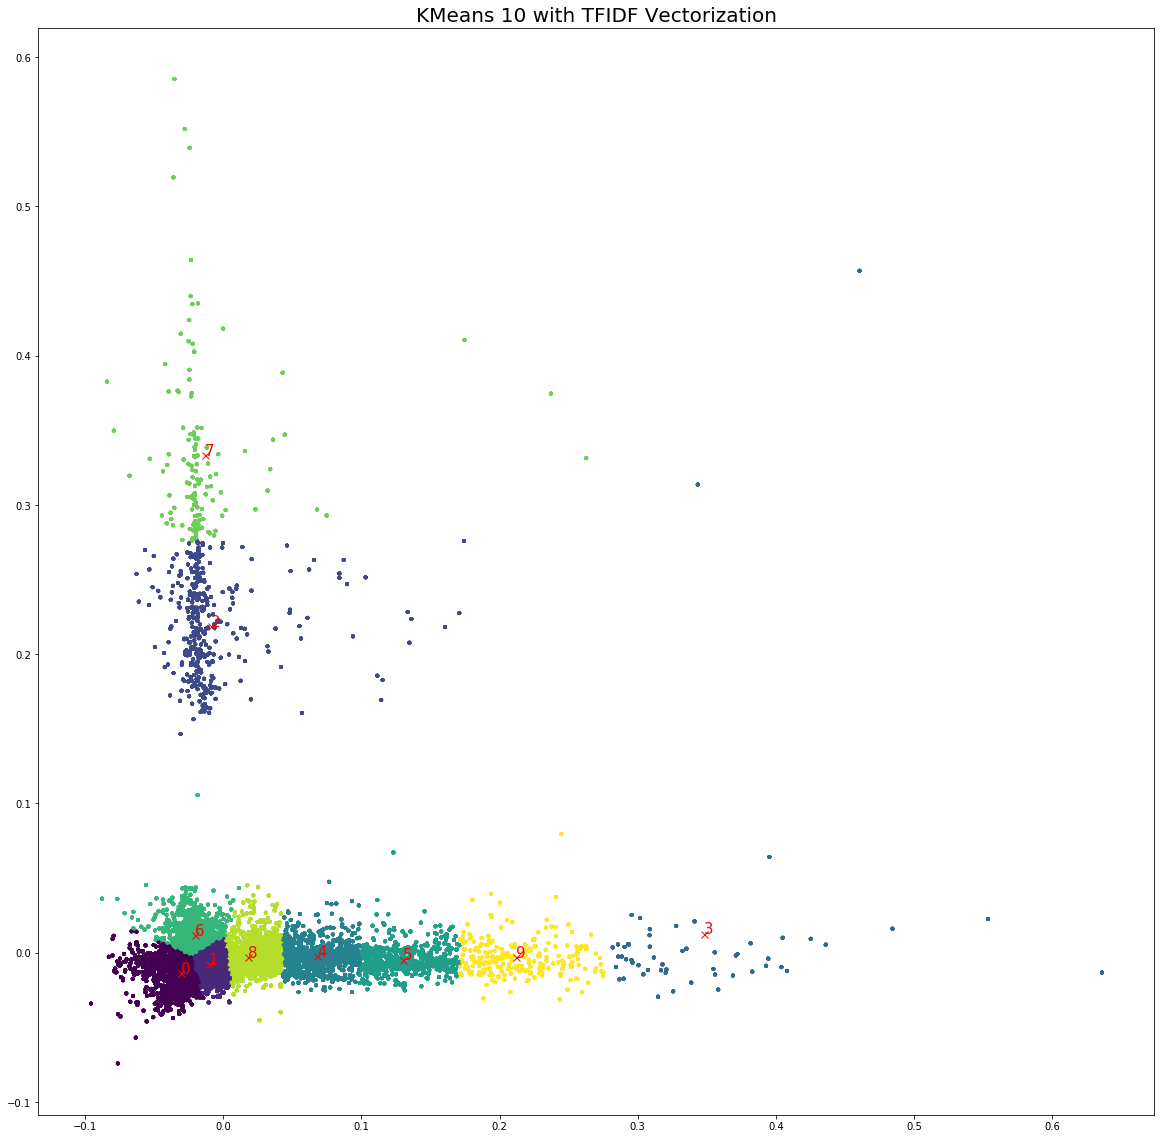

In [71]:
# visually check 

plt.figure(figsize=(20,20))
plt.title("KMeans 10 with TFIDF Vectorization", fontsize = 20)

for i in range(0, 20000):
    
    # scatter plot of samples
    cluster = data2D_df[data2D_df['nearest_10'] == i]
    plt.scatter(data2D_df[0],data2D_df[1], s=8, c= data2D_df['nearest_10'])
    
    # centroid is kmeans center
    centroid = kmeans_10.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = data2D_df['nearest_10'])
    plt.annotate(str(i),centroid,size=15, color = 'red')


## KMeans with TFIDF Observations

Visualizing KMeans with 50 centroids shows an excessive concentration on one spot so I didn't run KMeans 100. When I checked how the questions were grouping, it didn't perform that well either. I will be moving on to DBSCAN.

## DBSCAN

In [88]:
# make an array from data2D_df (TFIDF and sample = 20,000)

data2D_array = data2D_df[[0,1]].values

In [89]:
# initialize DBSCAN

db = DBSCAN(eps=0.005, min_samples= 7).fit(data2D_array)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


In [90]:
# create a labels class for visualization

data2D_df['db_labels'] = db.labels_
#sample_df['db_labels'] = db.labels_

In [91]:
# Number of clusters in labels, ignoring noise if present.

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# convert array into dataframe
sample_df = pd.DataFrame(data2D_array)


Text(0.5, 1.0, 'DBSCAN with TFIDF Vectorization')

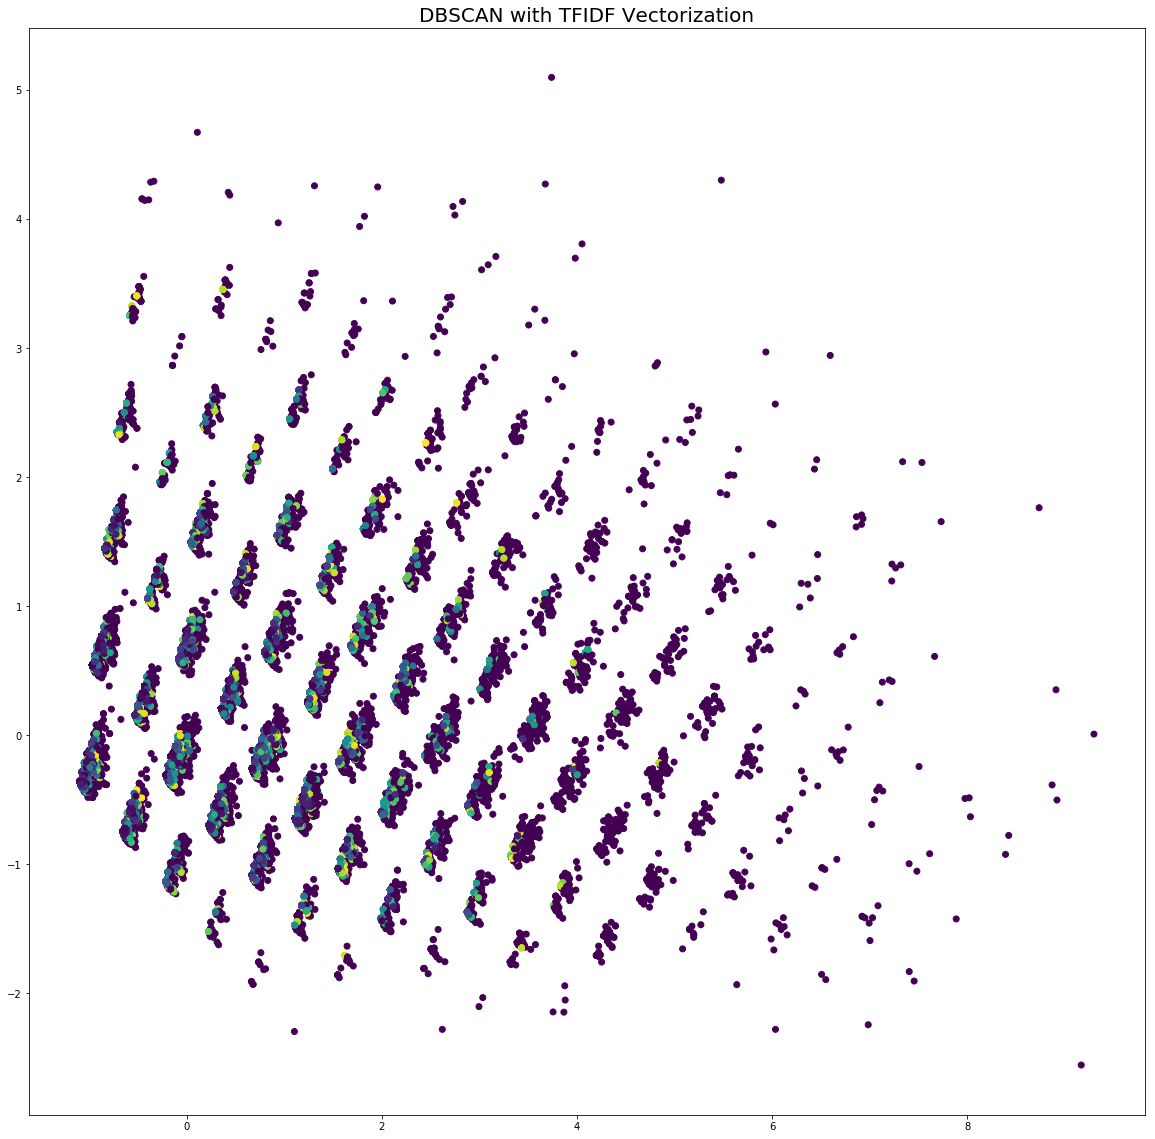

In [92]:
# Visualize DBSCAN with epsilon = 0.2, min_samples = 10:
fig = plt.figure(figsize=(20,20))
plt.scatter(data2D_df[0], data2D_df[1], c = db.labels_)
plt.title("DBSCAN with TFIDF Vectorization", fontsize = 20)

In [93]:
# heuristic check:

zero_index = data2D_df[data2D_df['db_labels'] == 3].index

for i in zero_index[:10]:
    print(df['Question'][i])

In the title of an Aesop fable, this insect shared billing with a grasshopper
Parts of the Arabian and Libyan deserts are found in this African country
Warhol became the manager of this Lou Reed rock group in 1965 & produced their first album
The amount of this in a solution can be measured by a saccharometer
Discovered by David Livingstone, Botswana's Lake Ngami lies in the northern part of this desert
This favorite horse of Alexander the Great sometimes wore golden horns in battle
In 1948 Douglas Edwards became the first anchor of this network's Evening News
In 1992 Space Shuttle astronauts delivered ashes of this "Star Trek" creator into the final frontier
In 960 Mieczyslaw I became the first ruler of this country
This 1904-1905 war began in Manchuria & ended with the battle of Tsushima Strait


## DBSCAN observation

DBSCAN on TFIDF extracted data isn't as useful because the observations are in a very tight cluster already. Even with a really low epsilon, the cluster groups is not particularly useful. Qualitative check also shows that the questions are not really related.

After checking heuristically, it is apparent that the questions are not related.

## Doc2Vec  (Model initialization and qualitative check)

In [94]:
# Transform pre-processed Jeopardy questions into a list 

with open('jeopardy.txt') as f:
    data = f.readlines()
    
doc2vec_data = []
for line in data:
    doc2vec_data.append(line)

len(doc2vec_data) # check everything was transformed correctly.

216887

In [95]:
# write another text file from doc2vec_data list

File = open('doc2vec_data.txt', 'w')

for item in doc2vec_data:
    File.write('%s' % item)

In [97]:
#Initialize and train model

sentences = gensim.models.doc2vec.TaggedLineDocument('doc2vec_data.txt')
model = gensim.models.doc2vec.Doc2Vec(sentences, size = 200, window = 10, min_count = 5, iter = 50, workers = 5)

/Users/queenbee/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/queenbee/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [98]:
# Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.

df['processed_text'] = df['Question'].map(lambda x: gensim.utils.simple_preprocess(x))

In [114]:
# Check most similar questions

sims = model.docvecs.most_similar(37)

print(sims)

[(134135, 0.5989274978637695), (196561, 0.5079987645149231), (168451, 0.5051314234733582), (94278, 0.5040464997291565), (123731, 0.4990909695625305), (127337, 0.496745228767395), (53553, 0.49305468797683716), (194162, 0.4905909597873688), (53388, 0.4898800253868103), (50305, 0.488028347492218)]


In [115]:
# Heuristic check

print('original question:', df['Question'].iloc[37], '\n', 'ANSWER:', df['Answer'].iloc[37])
for i in sims:
    print('question index', i[0],":" , df['Question'].iloc[i[0]], '\n', 'ANSWER:', df['Answer'].iloc[i[0]])

# Seems like the questions were grouped by 'cities'.

original question: Ali, who married this man's daughter Fatima, is considered by Shia Muslims to be his true successor 
 ANSWER: muhammed
question index 134135 : His son by the handmaid Hagar, considered the father of the Arabs 
 ANSWER: ishmael
question index 196561 : The Red Sea is considered an arm of this ocean 
 ANSWER: indian ocean
question index 168451 : His mother Jochebed was hired to be his nurse by Pharaoh's daughter 
 ANSWER: moses
question index 94278 : In Hinduism, Krishna is considered the eighth earthly incarnation of this preserver god 
 ANSWER: vishnu
question index 123731 : Snout beetle is another name for the true type of this insect 
 ANSWER: a weevil
question index 127337 : By 1513 da Vinci's patron was Giuliano, a member of this powerful Florentine family 
 ANSWER: the medicis
question index 53553 : Desi's daughter 
 ANSWER: luci arnaz
question index 194162 : A proposition presumed to be true 
 ANSWER: axiom
question index 53388 : If yours is "absolute", you know

In [116]:
# most similar check: 

print(model.most_similar(positive = ['america', 'football'], negative = ['china']))

[('basketball', 0.43813732266426086), ('qb', 0.4095137119293213), ('nba', 0.4033883213996887), ('american', 0.39264577627182007), ('coach', 0.38190072774887085), ('nfl', 0.3742930591106415), ('league', 0.3616204857826233), ('quarterback', 0.3614428639411926), ('the', 0.35735082626342773), ('carolina', 0.3534351587295532)]


/Users/queenbee/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  app.launch_new_instance()


In [117]:
# most similar (cosmul) check:
# CosMul amplifies the differences between small quantities and reduces the differences between larger ones.

print(model.most_similar_cosmul(positive= ['america', 'football'], negative = ['china']))

[('qb', 0.8529298305511475), ('basketball', 0.845082700252533), ('nba', 0.8141291737556458), ('coach', 0.8080244660377502), ('quarterback', 0.7984021306037903), ('american', 0.788863480091095), ('nfl', 0.7885275483131409), ('league', 0.7812668681144714), ('the', 0.768353283405304), ('for', 0.7652835249900818)]


/Users/queenbee/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).


## Doc2Vec (PCA and t-SNE dimension reduction visualization)

In [118]:
# Grab vectors for Doc2Vec model above
# The raw vectors array of words in a Doc2Vec model is available in model.wv.syn0

word_vecs = model.wv.syn0

/Users/queenbee/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


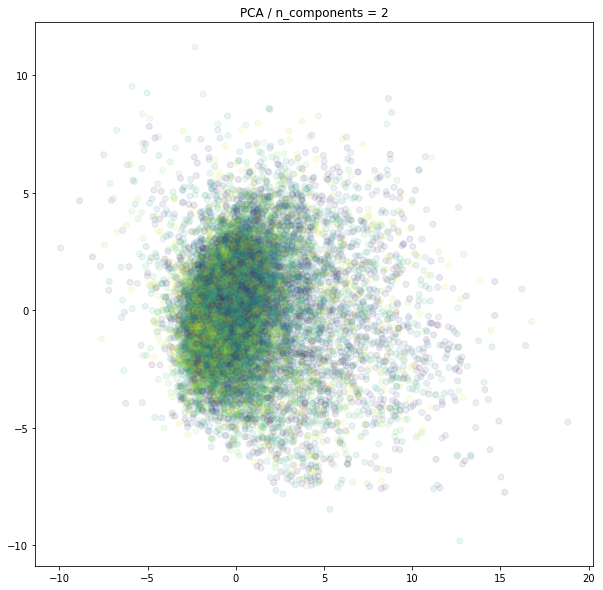

In [119]:
# used 2 dimensional PCA on Doc2Vec's vector
# not clustering too well.
# try many components and use the first two.

# It doesn't tell me anything.

# get topic keys
pca_keys = []
for i in range(word_vecs.shape[0]):
    pca_keys.append(word_vecs[i].argmax())

fig = plt.figure(figsize=(10,10))
pca = PCA(n_components = 2).fit(word_vecs)
data2D = pca.transform(word_vecs)
plt.scatter(data2D[:,0], data2D[:,1], alpha = .1, c = pca_keys)
plt.title("PCA / n_components = 2")
plt.show()  

In [120]:
# try T-SNE and see if it clusters better

tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca', perplexity= 50)
tsne = tsne_model.fit_transform(word_vecs)

In [121]:
# random initialization
tsne_model2 = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, learning_rate = 100, init='pca', perplexity= 50)
tsne2 = tsne_model2.fit_transform(word_vecs)

Text(0.5, 1.0, 'perplexity = 30 / PCA/ Learning Rate = 200')

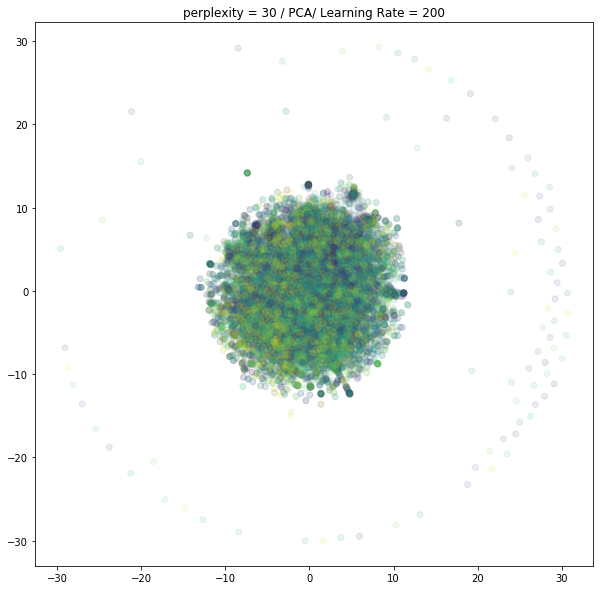

In [122]:
# Let's visualize the raw vectors that were transformed by T-SNE (perplexity = 30 used with PCA)


tsne_keys = []
for i in range(word_vecs.shape[0]):
    tsne_keys.append(word_vecs[i].argmax())

fig = plt.figure(figsize=(10,10))
plt.scatter(x= tsne[:, 0], y = tsne[:, 1], alpha = 0.1, c = tsne_keys)
plt.title(label = "perplexity = 30 / PCA/ Learning Rate = 200")

Text(0.5, 1.0, 'perplexity = 50 / PCA / Learning Rate = 200')

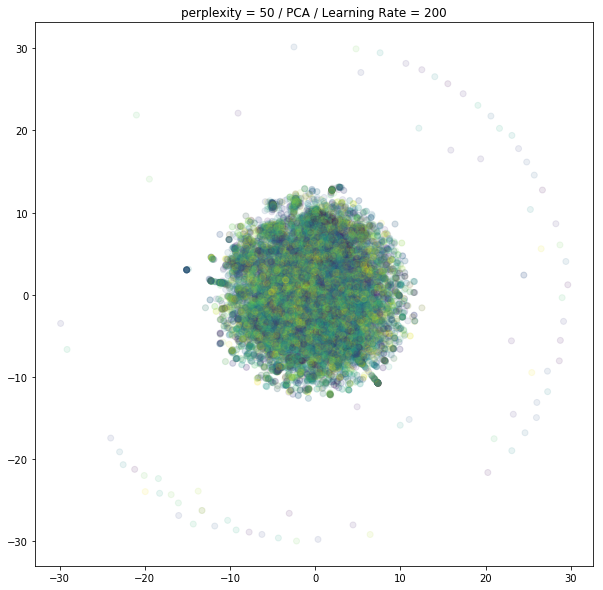

In [159]:
# Let's visualize the raw vectors that were transformed by T-SNE (perplexity = 50 used with PCA)

tsne_keys = []
for i in range(word_vecs.shape[0]):
    tsne_keys.append(word_vecs[i].argmax())

fig = plt.figure(figsize=(10,10))
plt.scatter(x= tsne[:, 0], y = tsne[:, 1], alpha = 0.1, c = tsne_keys)  
plt.title(label = "perplexity = 50 / PCA / Learning Rate = 200")

Text(0.5, 1.0, 'perplexity = 50 / PCA / Learning Rate = 100')

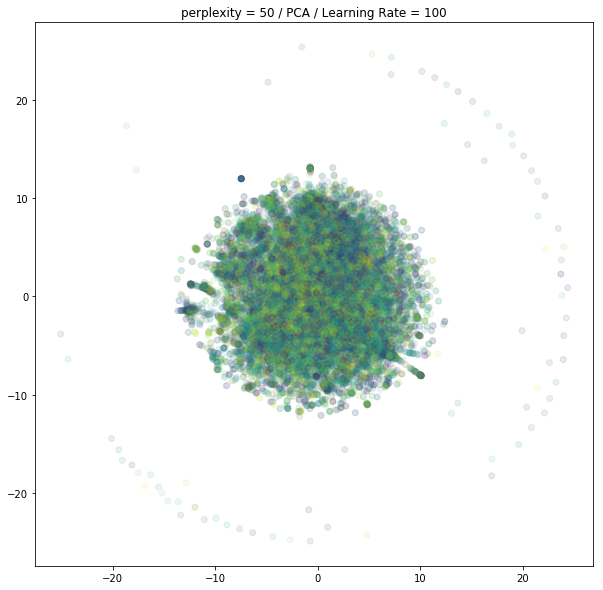

In [160]:
# Let's visualize the raw vectors that were transformed by T-SNE (perplexity = 50 used with PCA)

tsne2_keys = []
for i in range(word_vecs.shape[0]):
    tsne2_keys.append(word_vecs[i].argmax())

fig = plt.figure(figsize=(10,10))   
plt.scatter(x= tsne2[:, 0], y = tsne2[:, 1], alpha = 0.1, c = tsne2_keys)
plt.title(label = "perplexity = 50 / PCA / Learning Rate = 100")

## LDA Visualization with T-SNE

In [151]:
lda_model = LatentDirichletAllocation()
X_topics = lda_model.fit_transform(question_vec)

/Users/queenbee/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [152]:
# HEADS UP! This will take a long time.

tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')

tsne_lda = tsne_model.fit_transform(X_topics)

In [153]:
# tsne_lda to dataframe
tsne_lda_df = pd.DataFrame(tsne_lda)
len(tsne_lda_df)

216887

In [154]:
lda_keys = []
for i in range(X_topics.shape[0]):
    lda_keys +=  X_topics[i].argmax(),

len(lda_keys)

216887

In [155]:
# create class for 

lda_keys_df = pd.DataFrame(lda_keys)
lda_keys_df = lda_keys_df.rename(columns = {0: 'class'})

In [156]:
# merge tsne_lda_df with the likely topic for each question:

df2 = pd.concat([tsne_lda_df, lda_keys_df], axis=1)
df2.head()

,0,1,class
0,-25.068110,7.868075,5
1,17.991083,8.887013,2
2,15.464070,-22.100845,0
3,-4.081281,-21.239632,4
4,17.829142,-13.012856,2


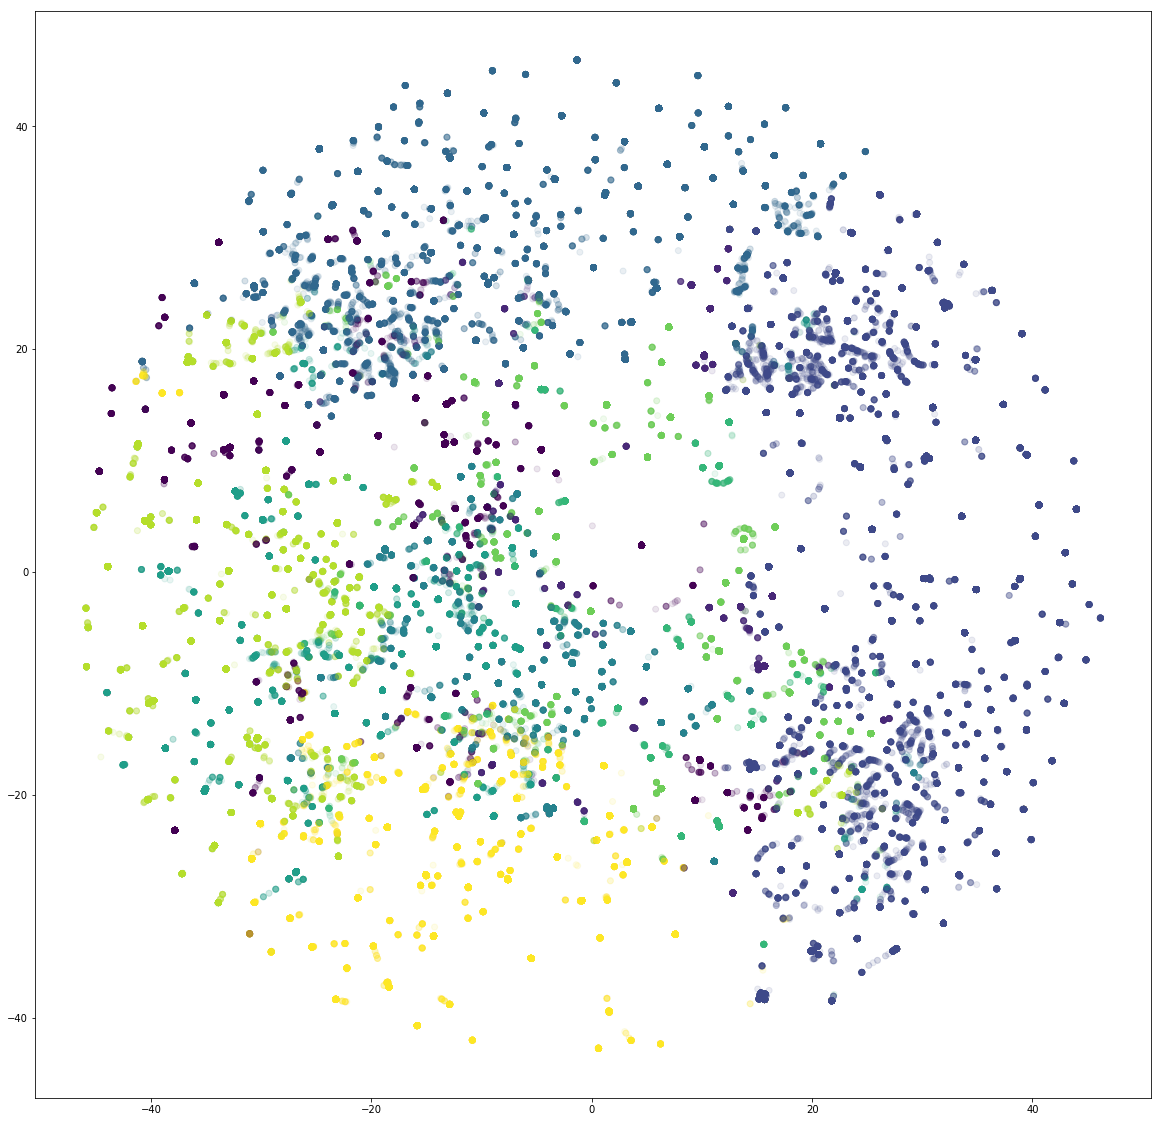

In [157]:
fig = plt.figure(figsize=(20,20))
plt.scatter(df2[0], df2[1], alpha = 0.1, c = df2['class'])

In [162]:
# heuristic measurement / quality check

indexed = df2[df2['class'] == 6].index

for i in indexed[:20]:
    print(df['Question'][i])

It can be a place to leave your puppy when you take a trip, or a carrier for him that fits under an airplane seat
It's a type of bounce house, or a dance made famous by Michael Jackson
As an adjective, it can mean proper; as a verb, "to grade papers"
Say the name of <a href="http://www.j-archive.com/media/2010-07-06_DJ_29.jpg" target="_blank">these</a> big trees; it has a color in it
It "Becomes Electra" (8)
People say these are what you need to make it in Hollywood
Arabic for "son of", it comes before names like Saud
Previously attached to Theo- & Isa-, it became popular by itself after appearing in "David Copperfield"
Wayne State, Kalamazoo College, Madonna University (it's Franciscan Catholic, not Material Girl)
It can be a pack of dogs, or a place to board them
He filed for divorce citing Leviticus 20:21, "If a man shall take his brother's wife, it is an unclean thing"
In a restaurant, it's a quartet's table request
It has over 9,700 tax preparation offices worldwide
A loop found o

### LDA Model Observation:

The questions are beginning to cluster better than KMeans and DBSCAN. For example, in the '9' class, there are questions relating to talk shows and comedies starting to come out frequently. There are historical/popular figures that are frequently coming up too and that bleeds into topics pertaining to the civil war, WWII, and other conflicts. 

For topics in the '6' class, there are a lot of 'name the object/person/city' questions. This particular cluster performed really well due to the keyword "It".

Overall, the model is not perfect but I can see a pattern beginning to form and some questions clustered better than others. 


## KMeans with t-SNE

In [201]:
tsne_df = df2.drop('class', axis = 1)

In [202]:
kmeans_10_tsne = KMeans(n_clusters = 25) 
model_10_tsne = kmeans_10_tsne.fit(tsne_df) 
tsne_clusters_10 = model_10_tsne.cluster_centers_ 
tsne_centroids_10 = pd.DataFrame(tsne_clusters_10)

In [203]:
# apply class by distance 
tsne_df['nearest_10'] = tsne_df.apply(lambda x: np.linalg.norm(tsne_centroids_10.sub(x[[0,1]]), axis =1).argmin(), axis = 1)


In [220]:
kmeans10_tsne_1 = tsne_df[tsne_df['nearest_10'] == 1].index


In [222]:
for i in kmeans10_tsne_1[:10]:
    print(df['Question'][i])

No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves
When it began on Pan Am & Qantas in the late '70s, it was basically a roped-off part of the economy cabin with free drinks
The shorter glass seen <a href="http://www.j-archive.com/media/2004-12-31_DJ_12.jpg" target="_blank">here</a>, or a quaint cocktail made with sugar & bitters
As an adjective, it can mean proper; as a verb, "to grade papers"
Prime Minister Tony Blair dubbed her "The People's Princess"
It "Becomes Electra" (8)
Flower seen here (that fits the category)
Bordering Italy, Austria, Hungary & Croatia, it's one of the world's newest independent countries
This descriptive nickname of the U.S. flag was coined by Francis Scott Key
Golfing "hole" with a bar (where you can't go), or the amendment granting women's suffrage


IndexError: index 25 is out of bounds for axis 0 with size 25

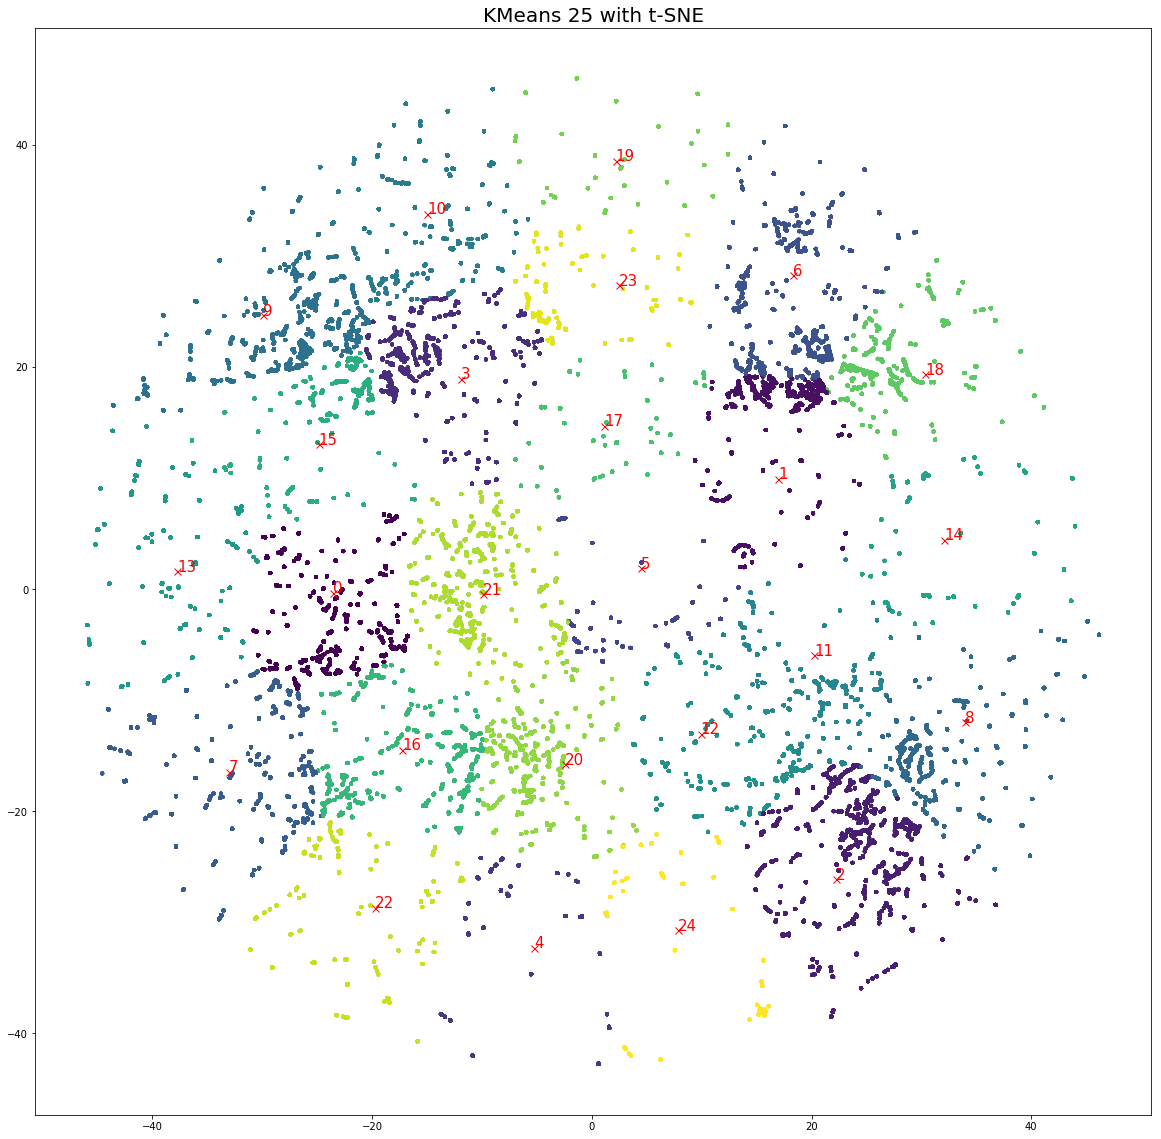

In [223]:
# visually check 

plt.figure(figsize=(20,20))
plt.title("KMeans 25 with t-SNE", fontsize = 20)

for i in range(0, 20000):
    
    # scatter plot of samples
    cluster = tsne_df[tsne_df['nearest_10'] == i]
    plt.scatter(tsne_df[0],tsne_df[1], s=8, c= tsne_df['nearest_10'])
    
    # centroid is kmeans center
    centroid = kmeans_10_tsne.cluster_centers_[i]
    
    # plot centroid
    plt.plot(centroid[0], centroid[1], marker='x', markersize=7, color='red', label = tsne_df['nearest_10'])
    plt.annotate(str(i),centroid,size=15, color = 'red')


## Concluding Thoughts

LDA with t-SNE started clustering questions in a recognizable pattern. When I applied KMeans with 25 centroids on top of the vectors decomposed by t-SNE, the questions began to look less related. There was a trade-off between interpretability and performance.

For next steps, I would consider creating a new feature called "real categories" where I sort and tag questions by their real topical categories and create a supervised learning model. This should drastically improve the performance of my model.